# Lecture 3

In [1]:
# Run this codeblock to mount your Google Drive in Google Colab.
# from google.colab import drive

# drive.mount("/content/drive/")

In [2]:
from pathlib import Path
import numpy as np
import cv2
import matplotlib.pylab as plt
import torch

ROOT = "./"  # TODO: set your root directory here
# ROOT = '/content/drive/MyDrive/실습1' # example for Google Drive

ROOT = Path(ROOT)
# Check if the root directory exists
if not ROOT.exists():
    print(f"Root directory {ROOT} does not exist. Please check the path.")

### Load and plot an image

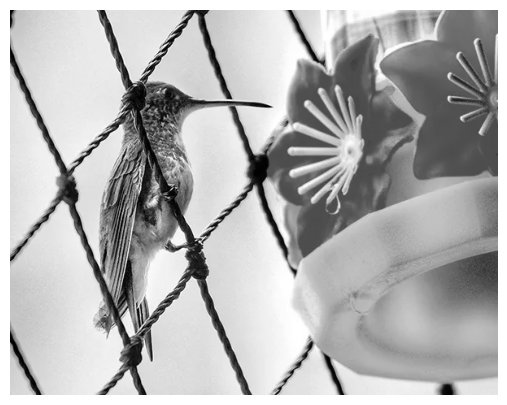

In [3]:
img = cv2.imread(ROOT / "bird.jpg", 0)
img = np.array(img)
img = torch.tensor(img, dtype=torch.float32)

plt.figure(figsize=(8, 5))
plt.imshow(img, cmap="gray")
plt.axis("off")
plt.show()

### Define FFT and IFFT

In [4]:
def fft2c(img: torch.Tensor) -> torch.Tensor:
    img_k = torch.fft.fftshift(torch.fft.fftn(img, dim=(-2, -1)), dim=(-2, -1))
    return img_k


def ifft2c(img_k: torch.Tensor) -> torch.Tensor:
    img = torch.fft.ifftn(torch.fft.ifftshift(img_k, dim=(-2, -1)), dim=(-2, -1))
    return img.real

### Plot the K-space of the image

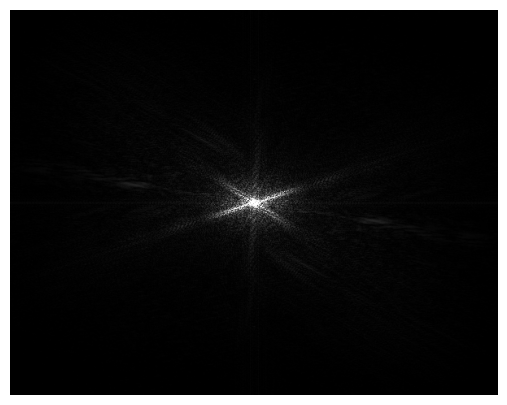

In [5]:
img_k = fft2c(img)
vmax = torch.max(torch.abs(img_k)) * 1e-2
vmin = 0

plt.figure(figsize=(8, 5))
plt.imshow(torch.abs(img_k), cmap="gray", vmin=vmin, vmax=vmax)
plt.axis("off")
plt.show()

### Restore the image

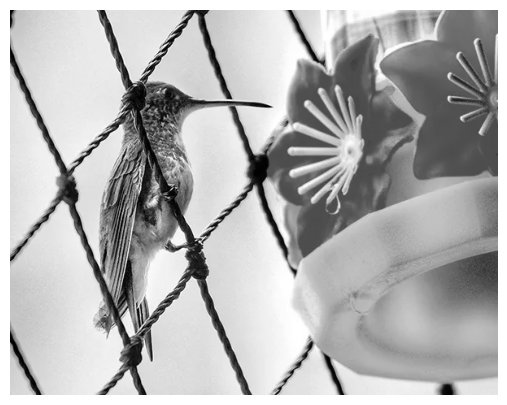

In [6]:
img = ifft2c(img_k)
img = torch.abs(img)
vmax = torch.max(img)
vmin = 0

plt.figure(figsize=(8, 5))
plt.imshow(img, cmap="gray", vmin=vmin, vmax=vmax)
plt.axis("off")
plt.show()

### Load and plot an antronaut

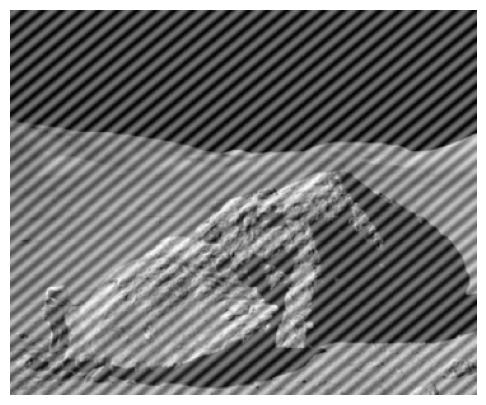

In [7]:
img = cv2.imread(ROOT / "astronaut.png", 0)
img = np.array(img)
img = torch.tensor(img, dtype=torch.float32)

plt.figure(figsize=(8, 5))
plt.imshow(img, cmap="gray")
plt.axis("off")
plt.show()

### Plot the K-space of the image

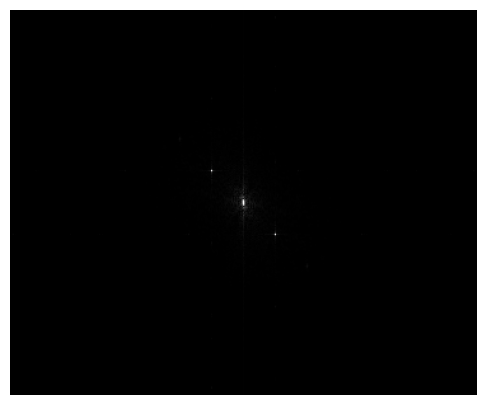

In [8]:
img_k = fft2c(img)
vmax = torch.max(torch.abs(img_k)) * 1e-1
vmin = 0

plt.figure(figsize=(8, 5))
plt.imshow(torch.abs(img_k), cmap="gray", vmin=vmin, vmax=vmax)
plt.axis("off")
plt.show()

### Remove K-space noise and restore the image

In [ ]:
# TODO: Remove noise from K-space and restore the image

value_threshold = torch.max(torch.abs(img_k)) * 0.003
distance_threshold = 30

###
# 1. 기존 threshold 및 중심 거리 계산
# 2. 먼 픽셀만 선택
# 3. 마스크 생성
# 4. dilation으로 주변 픽셀까지 확장 (3x3 커널)
# 5. 복사본 이미지에서 해당 위치를 0으로
center = torch.tensor(img_k.shape[-2:]) // 2
distances = torch.sqrt(
    (torch.arange(img_k.shape[0])[:, None] - center[0]) ** 2 +
    (torch.arange(img_k.shape[1])[None, :] - center[1]) ** 2
)
mask = (torch.abs(img_k) > value_threshold) & (distances > distance_threshold)
dilated_mask = torch.nn.functional.max_pool2d(
    mask.float().unsqueeze(0).unsqueeze(0), kernel_size=3, stride=1, padding=1
).squeeze(0).squeeze(0).bool()
img_k_rev = img_k.clone()
img_k_rev[dilated_mask] = 0
###

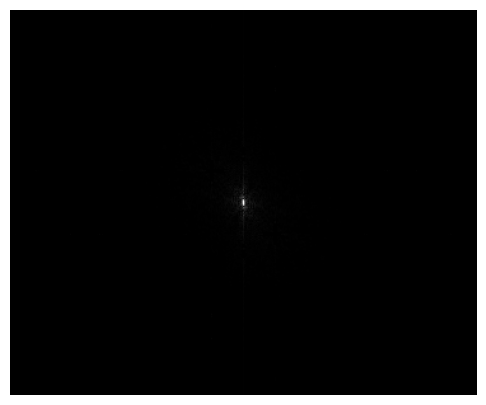

In [18]:
vmax = torch.max(torch.abs(img_k_rev)) * 1e-1
vmin = 0
plt.figure(figsize=(8, 5))
plt.imshow(torch.abs(img_k_rev), cmap="gray", vmin=vmin, vmax=vmax)
plt.axis("off")
plt.show()

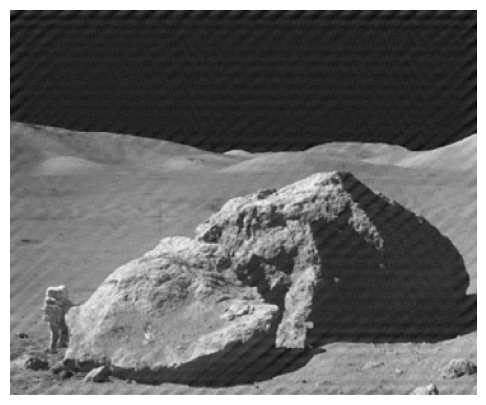

In [19]:
img = ifft2c(img_k_rev)
img = torch.abs(img)
vmax = torch.max(img)
vmin = torch.min(img)

plt.figure(figsize=(8, 5))
plt.imshow(img, cmap="gray", vmin=vmin, vmax=vmax)
plt.axis("off")
plt.show()

### Gaussian lowpass filter

In [84]:
#: TODO: Define the Gaussian kernel function
def gaussian_kernel(h, w, sigma=0.2):
    x = torch.arange(-w // 2, w // 2 + 1, dtype=torch.float32)
    y = torch.arange(-h // 2, h // 2 + 1, dtype=torch.float32)
    x, y = torch.meshgrid(x, y, indexing='ij')
    kernel = torch.exp(-(x**2 + y**2) / (2 * sigma**2))
    # kernel = kernel / torch.sum(kernel)  # Normalize the kernel
    return kernel


img = cv2.imread(ROOT / "bird.jpg", 0)
img = np.array(img)
img = torch.tensor(img, dtype=torch.float32)

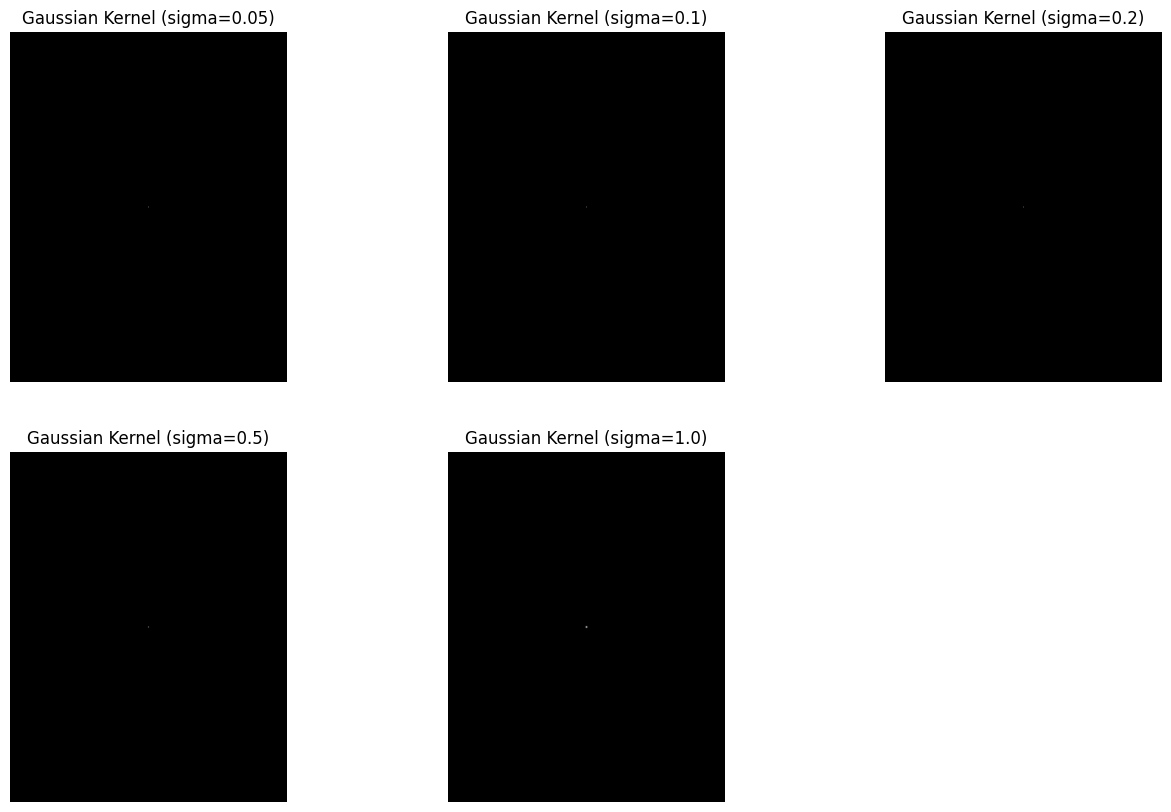

In [82]:
sigma_list = [0.05, 0.1, 0.2, 0.5, 1.0]
H, W = img.shape
plt.figure(figsize=(16, 10))
for i, sigma in enumerate(sigma_list):
    kernel = gaussian_kernel(H, W, sigma=sigma)
    vmax = torch.max(kernel)
    vmin = 0

    plt.subplot(2, 3, i + 1)
    plt.imshow(kernel, cmap="gray", vmin=vmin, vmax=vmax)
    plt.title(f"Gaussian Kernel (sigma={sigma})")
    plt.axis("off")

### Plot Gauss kernel

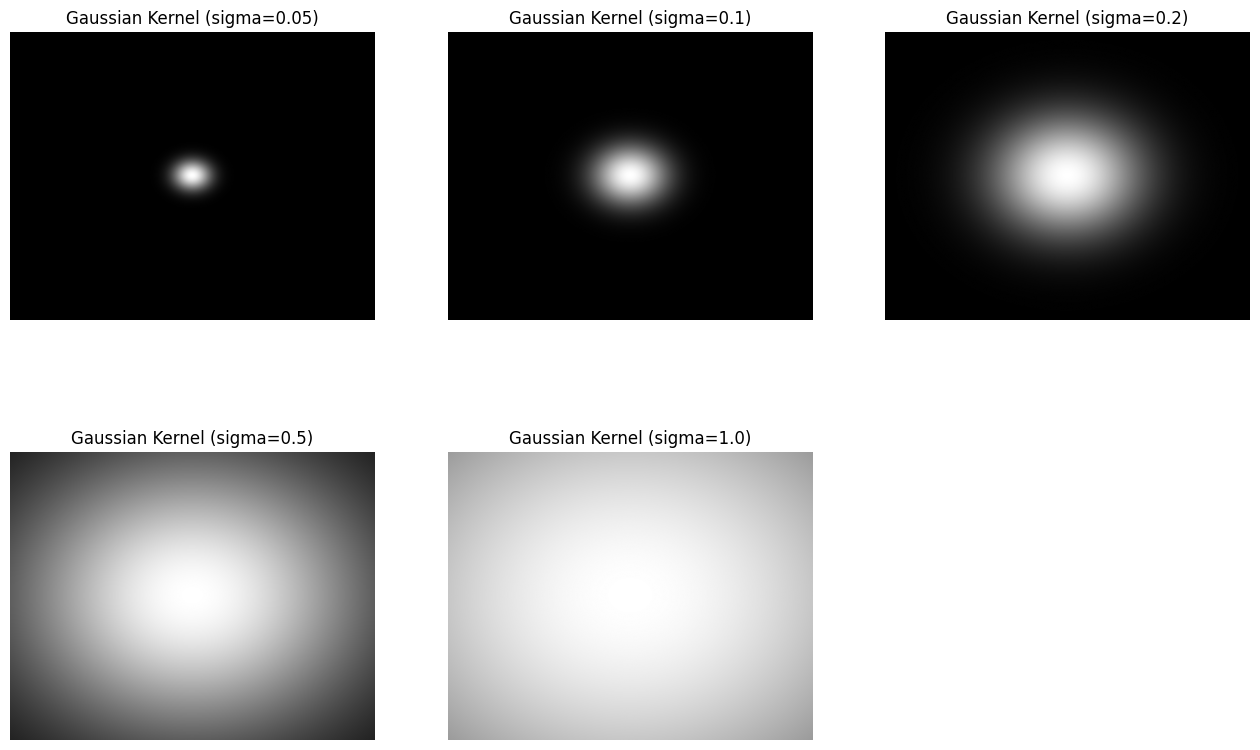

In [204]:
sigma_list = [0.05, 0.1, 0.2, 0.5, 1.0]
H, W = img.shape
plt.figure(figsize=(16, 10))
for i, sigma in enumerate(sigma_list):
    kernel = gaussian_kernel(H, W, sigma=sigma)
    vmax = torch.max(kernel)
    vmin = 0

    plt.subplot(2, 3, i + 1)
    plt.imshow(kernel, cmap="gray", vmin=vmin, vmax=vmax)
    plt.title(f"Gaussian Kernel (sigma={sigma})")
    plt.axis("off")

### Apply lowpass filter to image

In [85]:
def loss_pass_filter(img, sigma=0.05):
    H, W = img.shape
    kernel = gaussian_kernel(H, W, sigma=sigma)

    img_k = fft2c(img)
    img_k_filtered = img_k * kernel
    img_filtered = ifft2c(img_k_filtered)

    return torch.abs(img_filtered), img_k_filtered


img_k = fft2c(img)
img_filtered, img_k_filtered = loss_pass_filter(img, sigma=0.05)

vmin = torch.min(torch.abs(img_k_filtered)) * 1e-3
vmax = torch.max(torch.abs(img_k_filtered)) * 1e-3

plt.figure(figsize=(16, 10))
plt.subplot(2, 2, 1)
plt.imshow(img, cmap="gray")
plt.title("Original Image")
plt.axis("off")
plt.subplot(2, 2, 2)
plt.imshow(img_filtered, cmap="gray")
plt.title("Filtered Image")
plt.axis("off")
plt.subplot(2, 2, 3)
plt.imshow(torch.abs(img_k), cmap="gray", vmin=vmin, vmax=vmax)
plt.title("FFT of Original Image")
plt.axis("off")
plt.subplot(2, 2, 4)
plt.imshow(torch.abs(img_k_filtered), cmap="gray", vmin=vmin, vmax=vmax)
plt.title("FFT of Filtered Image")
plt.axis("off")
plt.show()

RuntimeError: The size of tensor a (600) must match the size of tensor b (475) at non-singleton dimension 1

### Apply highpass filter to image

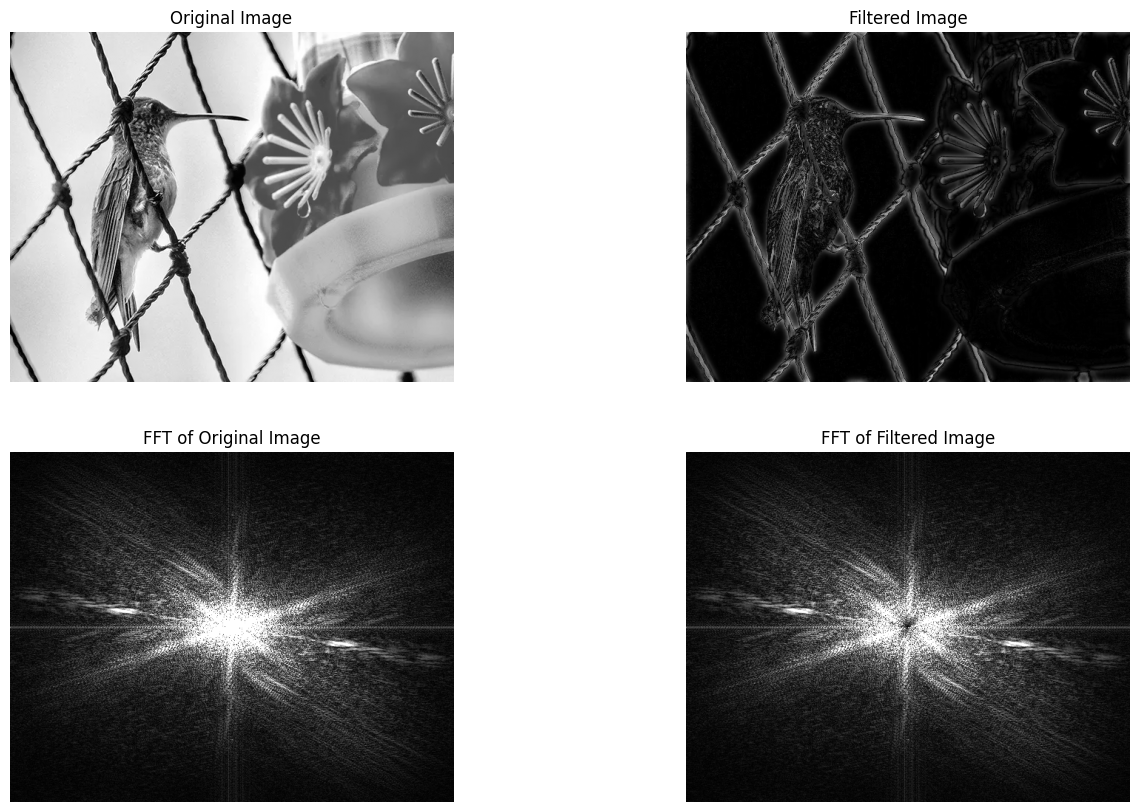

In [ ]:
# TODO: Apply highpass filter to image
def high_pass_filter(img, sigma=0.05):
    
    return torch.abs(img_filtered), img_k_filtered


img_k = fft2c(img)
img_filtered, img_k_filtered = high_pass_filter(img, sigma=0.05)

vmin = torch.min(torch.abs(img_k)) * 1e-3
vmax = torch.max(torch.abs(img_k)) * 1e-3

plt.figure(figsize=(16, 10))
plt.subplot(2, 2, 1)
plt.imshow(img, cmap="gray")
plt.title("Original Image")
plt.axis("off")
plt.subplot(2, 2, 2)
plt.imshow(img_filtered, cmap="gray")
plt.title("Filtered Image")
plt.axis("off")
plt.subplot(2, 2, 3)
plt.imshow(torch.abs(img_k), cmap="gray", vmin=vmin, vmax=vmax)
plt.title("FFT of Original Image")
plt.axis("off")
plt.subplot(2, 2, 4)
plt.imshow(torch.abs(img_k_filtered), cmap="gray", vmin=vmin, vmax=vmax)
plt.title("FFT of Filtered Image")
plt.axis("off")
plt.show()

### Apply Laplacian

(np.float64(-0.5), np.float64(255.5), np.float64(351.5), np.float64(-0.5))

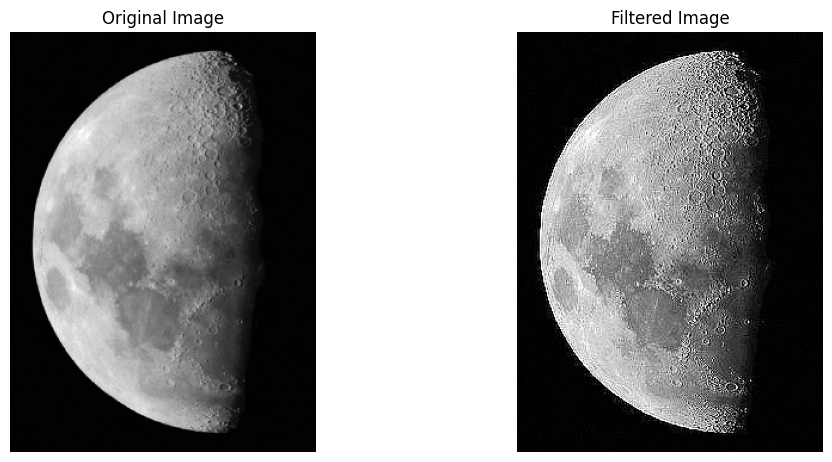

In [ ]:
img = cv2.imread(ROOT / "moon.jpg", 0)
img = np.array(img)
img = torch.tensor(img, dtype=torch.float32)


# TODO: Apply Laplacian
def laplacian_filter(h, w) -> torch.Tensor:
    ###

    ###
    return kernel


H, W = img.shape
kernel = laplacian_filter(H, W)
img_k = fft2c(img)
img_k_filtered = img_k * kernel
img_filtered = ifft2c(img_k_filtered)
vmin = torch.min(torch.abs(img))
vmax = torch.max(torch.abs(img))
plt.figure(figsize=(12, 12))
plt.subplot(2, 2, 1)
plt.imshow(img, cmap="gray", vmin=vmin, vmax=vmax)
plt.title("Original Image")
plt.axis("off")
plt.subplot(2, 2, 2)
plt.imshow(img_filtered, cmap="gray", vmin=vmin, vmax=vmax)
plt.title("Filtered Image")
plt.axis("off")